### Contoh Implementasi Fungsi Prediksi EQTransformer
menggunakan fungsi prediksi predict() yang berada di file eqt_predict_tf29.py, fungsi prediksi predict() sudah di rewrite untuk streaming data memproses satu data dan mengeluarkan satu prediksi dan kompatibel dengan tensorflow 2.9

In [ ]:
import tensorflow as tf
from keras.models import load_model
from source.lib.eqt_tf29.utils import SeqSelfAttention, FeedForward, LayerNormalization, f1

GPU_MEMORY_LIMIT=2050
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_MEMORY_LIMIT)]
        )
        print(f"Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print("Error setting GPU configuration:", e)
else:
    print("No GPU found. Using CPU.")


model = load_model(
    "resources/EqT_model_original.h5",
    custom_objects={
        'SeqSelfAttention': SeqSelfAttention,
        'FeedForward': FeedForward,
        'LayerNormalization': LayerNormalization,
        'f1': f1
    }
)

print("model loaded")

Using GPU: /physical_device:GPU:0
model loaded


### Contah data prediksi yang di ambil dari STEAD (Stanford Earthquake Data)

Trace key: 109C.TA_20070418093344_EV
Trace shape: (6000, 3)

Attributes:
back_azimuth_deg: 282.5
coda_end_sample: [[3165]]
network_code: TA
p_arrival_sample: 900.0
p_status: manual
p_travel_sec: 17.110000610351562
p_weight: 0.5
receiver_code: 109C
receiver_elevation_m: 150.0
receiver_latitude: 32.8889
receiver_longitude: -117.1051
receiver_type: BH
s_arrival_sample: 2079.0
s_status: manual
s_weight: 0.5
snr_db: [38.400002 37.       37.5     ]
source_depth_km: 13.3
source_depth_uncertainty_km: 
source_distance_deg: 0.92
source_distance_km: 101.92
source_error_sec: 0.7328
source_gap_deg: 38.102
source_horizontal_uncertainty_km: 3.1774
source_id: 11928303
source_latitude: 32.6944
source_longitude: -116.0417
source_magnitude: 2.8
source_magnitude_author: 
source_magnitude_type: ml
source_mechanism_strike_dip_rake: 
source_origin_time: 2007-04-18 09:33:37.06
source_origin_uncertainty_sec: 0.3
trace_category: earthquake_local
trace_name: 109C.TA_20070418093344_EV
trace_start_time: 2007-04-18

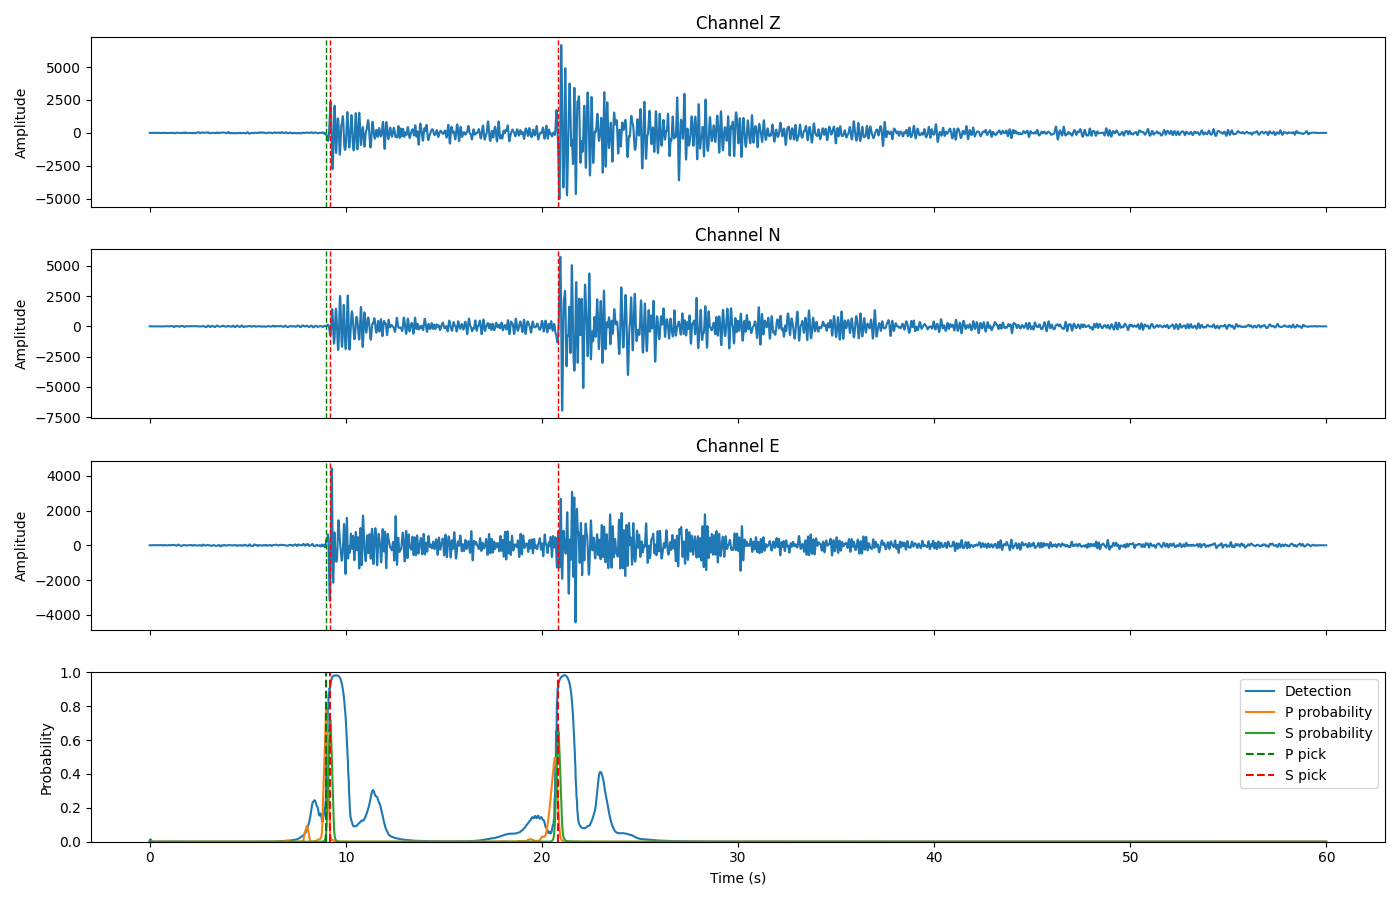

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from source.lib.eqt_tf29.core import predict

HDF5_PATH = r"datasets/100hz/waveform.hdf5"
TRACE_INDEX = 17

FS = 100.0 
WINDOW_SAMPLES = 6000

DET_THRESHOLD = 0.8
P_THRESHOLD   = 0.5
S_THRESHOLD   = 0.5
MIN_DISTANCE_SEC = 0.5

with h5py.File(HDF5_PATH, "r") as f:
    g = f["data"]
    key = list(g.keys())[TRACE_INDEX]
    seismic_trace = g[key][...]        
    seismic_trace_b = np.expand_dims(seismic_trace, axis=0)
    dset = g[key]
    print("Trace key:", key)
    print("Trace shape:", seismic_trace.shape)
    print("\nAttributes:")
    for k, v in dset.attrs.items():
        print(f"{k}: {v}")
    print("trace data:")
    print(dset[...])

prediction = predict(model, seismic_trace_b)

det = prediction["DD_mean"].squeeze(axis=0)
p   = prediction["PP_mean"].squeeze(axis=0)
s   = prediction["SS_mean"].squeeze(axis=0)

np.set_printoptions(suppress=True) 
np.set_printoptions(precision=6)

print("detection probability time series array :\n", det)
print("P Pick Probability time series array :\n", p)
print("S Pick Probability time series array :\n", s)

print("detection probability prediction length:", len(det))
print("P Pick Probability prediction length:" , len(p))
print("S Pic Probability prediction length:" , len(s))

dt = 1.0 / FS
t = np.arange(WINDOW_SAMPLES) * dt
MIN_DISTANCE = int(MIN_DISTANCE_SEC * FS)

p_peaks, s_peaks = [], []

p_peaks, _ = find_peaks(p, height=P_THRESHOLD, distance=MIN_DISTANCE)
s_peaks, _ = find_peaks(s, height=S_THRESHOLD, distance=MIN_DISTANCE)

p_times = np.array(p_peaks) * dt
s_times = np.array(s_peaks) * dt

print("P picks (s):", p_times)
print("S picks (s):", s_times)

fig, axes = plt.subplots(4, 1, figsize=(14, 9), sharex=True)
channel_titles = ["Channel Z", "Channel N", "Channel E"]

for i in range(3):
    axes[i].plot(t, seismic_trace[:, i])
    axes[i].set_title(channel_titles[i])
    axes[i].set_ylabel("Amplitude")

    for pt in p_times:
        axes[i].axvline(pt, color="green", linestyle="--", linewidth=1)

    for st in s_times:
        axes[i].axvline(st, color="red", linestyle="--", linewidth=1)

axes[3].plot(t, det, label="Detection")
axes[3].plot(t, p, label="P probability")
axes[3].plot(t, s, label="S probability")

for pt in p_times:
    axes[3].axvline(pt, color="green", linestyle="--", label="P pick")

for st in s_times:
    axes[3].axvline(st, color="red", linestyle="--", label="S pick")

axes[3].set_ylim(0.0, 1.0)
axes[3].set_ylabel("Probability")
axes[3].set_xlabel("Time (s)")

handles, labels = axes[3].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
axes[3].legend(by_label.values(), by_label.keys(), loc="upper right")

for ax in axes[:-1]:
    ax.label_outer()

plt.tight_layout()
plt.show()


### Contoh data yang diprediksi  dari real time system yang dijalankan

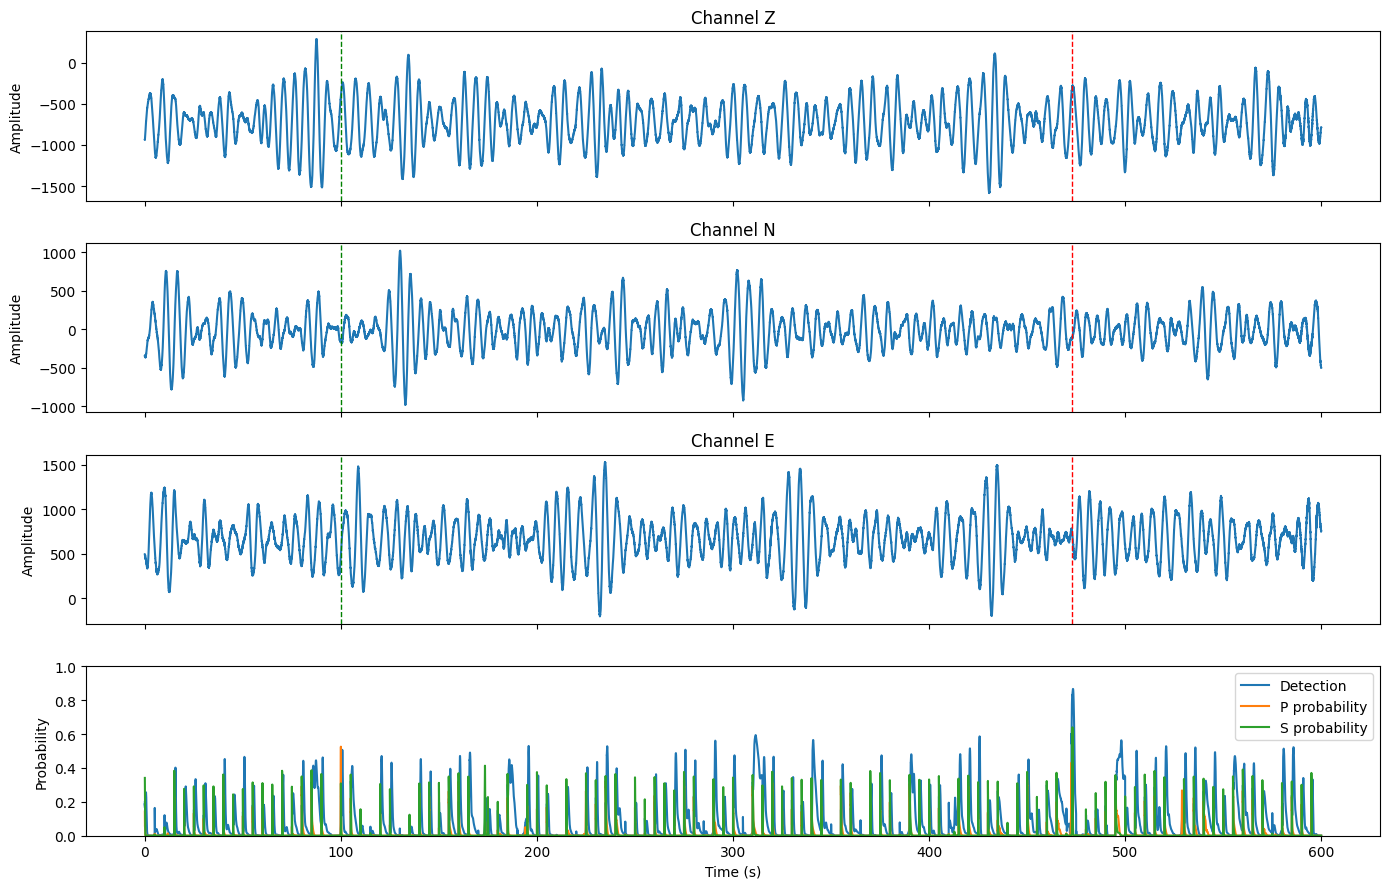

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from cassandra.cluster import Cluster
from minio import Minio
import io
from scipy.signal import find_peaks

CASSANDRA_HOSTS = ['127.0.0.1']
KEYSPACE = 'seismic'
TABLE = 'window_predictions'

MINIO_ENDPOINT = "localhost:9000"
MINIO_ACCESS_KEY = "minioadmin"
MINIO_SECRET_KEY = "minioadmin"
MINIO_BUCKET = "seismic"

DET_THRESHOLD = 0.8
P_THRESHOLD = 0.5
S_THRESHOLD = 0.5
MIN_DISTANCE_SEC = 0.5

FS = 100
WINDOW_SEC = 60
WINDOW_SAMPLES = int(WINDOW_SEC * FS)

cluster = Cluster(CASSANDRA_HOSTS)
session = cluster.connect(KEYSPACE)

rows = session.execute(
    f"""
    SELECT * FROM {TABLE}
    WHERE key = %s AND model_name = %s
    ORDER BY starttime ASC
    """,
    ("XL.MG08.HH", "EqTransformer-original")
)

minio_client = Minio(
    MINIO_ENDPOINT,
    access_key=MINIO_ACCESS_KEY,
    secret_key=MINIO_SECRET_KEY,
    secure=False
)

all_traces, all_det, all_p, all_s = [], [], [], []

for row in rows:
    response = minio_client.get_object(MINIO_BUCKET, row.minio_ref)
    data_bytes = response.read()
    response.close()
    response.release_conn()

    with np.load(io.BytesIO(data_bytes)) as f:
        all_traces.append(f["trace"])  # (N, 3)
        all_det.append(f["dd"])        # (N,)
        all_p.append(f["pp"])          # (N,)
        all_s.append(f["ss"])          # (N,)

merged_trace = np.concatenate(all_traces, axis=0)
merged_det   = np.concatenate(all_det)
merged_p     = np.concatenate(all_p)
merged_s     = np.concatenate(all_s)


start_sample = 0
win_len = 60000

end_sample = start_sample + win_len

trace_win = merged_trace[start_sample:end_sample]
det_win   = merged_det[start_sample:end_sample]
p_win     = merged_p[start_sample:end_sample]
s_win     = merged_s[start_sample:end_sample]


dt = 1.0 / FS
t = np.arange(trace_win.shape[0]) * dt

MIN_DISTANCE = int(MIN_DISTANCE_SEC * FS)

p_peaks, _ = find_peaks(p_win, height=P_THRESHOLD, distance=MIN_DISTANCE)
s_peaks, _ = find_peaks(s_win, height=S_THRESHOLD, distance=MIN_DISTANCE)

fig, axes = plt.subplots(4, 1, figsize=(14, 9), sharex=True)

channel_titles = ["Channel Z", "Channel N", "Channel E"]

for i in range(3):
    axes[i].plot(t, trace_win[:, i])
    axes[i].set_title(channel_titles[i])
    axes[i].set_ylabel("Amplitude")

    for pt in p_peaks * dt:
        axes[i].axvline(pt, color="green", linestyle="--", linewidth=1)

    for st in s_peaks * dt:
        axes[i].axvline(st, color="red", linestyle="--", linewidth=1)

# Probabilities
axes[3].plot(t, det_win, label="Detection")
axes[3].plot(t, p_win, label="P probability")
axes[3].plot(t, s_win, label="S probability")
axes[3].set_ylim(0.0, 1.0)
axes[3].set_ylabel("Probability")
axes[3].set_xlabel("Time (s)")
axes[3].legend(loc="upper right")

plt.tight_layout()
plt.show()
